# Lesson 04 - Feature selection and Grid search

In this lesson, you will use a simple technique to tune hyperparameters of your models called GridSearch.

In [1]:
import pandas as pd
import numpy as np

import sklearn

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


## Load data and basic info

Let's load the same dataset as in Lesson 01.

In [2]:
bugs = pd.read_csv('./data/bugs_train.csv', parse_dates=['Opened', 'Changed'], index_col=None)

In [3]:
bugs.head(4)

,Component,Assignee,Status,Summary,Opened,Changed,Priority,Severity,Resolution
0,Debug,eclipse,VERIFIED,Icons needed for actions (1GI5UXW),2001-10-10 22:14:41,2001-10-18 11:51:14,P1,enhancement,FIXED
1,Debug,darin.eclipse,RESOLVED,README: Hit count not reset (1GET20Y),2001-10-10 22:14:42,2001-11-28 13:42:46,P3,normal,WORKSFORME
2,Debug,darin.eclipse,CLOSED,Use styled text in console (1G9S1YF),2001-10-10 22:14:43,2002-06-26 11:32:05,P3,normal,WONTFIX
3,Debug,eclipse,VERIFIED,StringBuffer representation (1GE3BFA),2001-10-10 22:14:44,2014-12-02 06:37:26,P3,normal,FIXED


## The classification task (the problem to solve)

Our task remains the same for this lesson - we would be to predict what will be the resolution of the defect report (y) based on the description of a defect (X). 

## Data preparation (features)

Let's quickly replicate processing of the Component and Severity features, as well as converting the decision class.

In [45]:
# we will make a copy of the main data
bugs_small = bugs[["Assignee", "Component", "Severity", "Status", "Priority", "Opened", "Changed", "Summary", "Resolution"]]

# Component
bugs_small = pd.get_dummies(bugs_small, columns=['Component'], prefix="Component")

# Severity
bugs_small['Severity'] = bugs_small['Severity'].map(
    {'enhancement':0, 'trivial':1, 'minor':2, 'normal':3, 'major':4, 'critical':5, 'blocker':6})

# Status
bugs_small['Status'] = bugs_small['Status'].map(
    {'VERIFIED':0, 'RESOLVED':1, 'CLOSED':2})

# Priority
bugs_small['Priority'] = bugs_small['Priority'].map(
    {'P1':1, 'P2':2, 'P3':3, 'P4':4, 'P5':5})


y = bugs_small['Resolution']
X = bugs_small.drop(['Resolution'], axis=1, inplace=False)


# Days
X['Days'] = X.apply(lambda x: (x.Changed - x.Opened).days, axis=1)
X.drop(["Changed", "Opened"], inplace=True, axis=1)

# Summary as BoW
X['Summary'] = X['Summary'].fillna('')
from sklearn.feature_extraction.text import CountVectorizer

# create CountVectorizer class; we take only 30 most frequently appearing features
count_vect = CountVectorizer(max_features=30, stop_words="english")

# CountVectorizer fit method extracts vocabulary while transform performs the transformation. There is also
# the method fit_transform that does both.
bag_of_words = count_vect.fit_transform(list(X['Summary'])).todense()

# We create a list of names of columns 
colnames = ["Summary_"+x for x in sorted(count_vect.vocabulary_.keys())]

# Finally, we create a dataframe with bag of words features
summary_bow = pd.DataFrame(bag_of_words, columns=colnames)
X = pd.concat([X.reset_index(drop=True), summary_bow], axis=1)
X.drop(["Summary"], inplace=True, axis=1)

# Assignee
inbox = [1 if x.endswith('-inbox') else 0 for x in bugs_small['Assignee']]
X.insert(loc=0, column='Assignee_Inbox', value=pd.Series(inbox))
    
eclipse = [1 if x.endswith('eclipse') else 0 for x in bugs_small['Assignee']]
X.insert(loc=0, column='Assignee_Eclipse', value=pd.Series(eclipse))
X.drop(["Assignee"], inplace=True, axis=1)

# decision class simplified to two - Fixed and Not Fixed
y_binary = np.array([1 if x == "FIXED" else 0 for x in y])
y_binary

from sklearn.preprocessing import LabelEncoder

# create an instance of the class
y_encoder = LabelEncoder()

# fit the converter to the data
y_encoder.fit(y)

# let's see the mapping
for y_label in y.unique():
    print(y_label, y_encoder.transform([y_label]))

# convert y to numbers
y = y_encoder.transform(y)



FIXED [1]
WORKSFORME [5]
WONTFIX [4]
DUPLICATE [0]
INVALID [2]
NOT_ECLIPSE [3]


In [5]:
X.head(4)

,Assignee_Eclipse,Assignee_Inbox,Severity,Status,Priority,Component_APT,Component_Core,Component_Debug,Component_Doc,Component_Text,...,Summary_npe,Summary_package,Summary_project,Summary_quick,Summary_refactoring,Summary_search,Summary_source,Summary_type,Summary_view,Summary_work
0,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,3,1,3,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,3,2,3,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,3,0,3,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Feature normalization

It is very likely that your features will use different scales. It may have a big impact on some of the machine learning algorithms. Also, it is often required to preserve a certain type of probability distribution (e.g. normal). 

In the following steps, we will learn two basic transformations -> min-max normalization, and standardization. You can find more scalers in the sklearn library.

In [6]:
from sklearn import preprocessing

### Min-max scaler

It changes the range of the variable by normalizing all the original values with their range. As a result, the scale range is between 0 and 1 and the original distribution shape is preserved. This method is very useful for preparing input for the neural networks or algorithms that calculate distance (e.g., K-NN).

Please note that the scaler can have a different output range than 0-1, but this is how we usually use it.

In [7]:
# We create a scaler
minmax_scaler = preprocessing.MinMaxScaler()

# We need to provide it a sample data (here we will use the whole dataset)
minmax_scaler.fit(X)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [8]:
# We use it like this
minmax_scaler.transform(X)

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.        , 0.5       , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.        , 0.5       , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 1.        , 0.        , ..., 0.        , 0.33333333,
        0.        ],
       [0.        , 0.        , 0.66666667, ..., 0.25      , 0.        ,
        0.        ],
       [0.        , 1.        , 0.5       , ..., 0.        , 0.        ,
        0.        ]])

In [9]:
# We can pack it back to a DataFrame
X_minmax = pd.DataFrame(minmax_scaler.transform(X), columns=X.columns)
X_minmax.head(4)

,Assignee_Eclipse,Assignee_Inbox,Severity,Status,Priority,Component_APT,Component_Core,Component_Debug,Component_Doc,Component_Text,...,Summary_npe,Summary_package,Summary_project,Summary_quick,Summary_refactoring,Summary_search,Summary_source,Summary_type,Summary_view,Summary_work
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.5,0.5,0.5,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.5,1.0,0.5,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.5,0.0,0.5,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's compare distributions of three types of features (scale-wise) before and after the transformation: Days, Severity, and Assignee_Eclipse

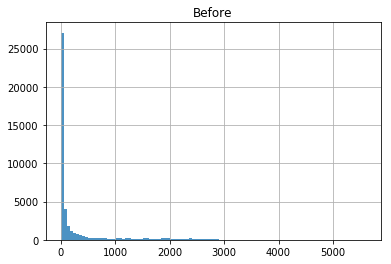

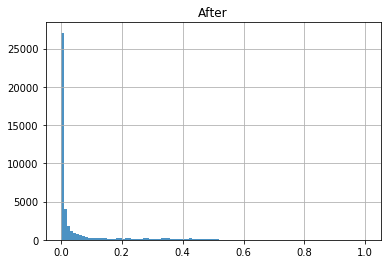

In [10]:
X.Days.hist(bins=100, alpha=0.8)
plt.title("Before")
plt.show()
plt.close()

X_minmax.Days.hist(bins=100, alpha=0.8)
plt.title("After")
plt.show()
plt.close()

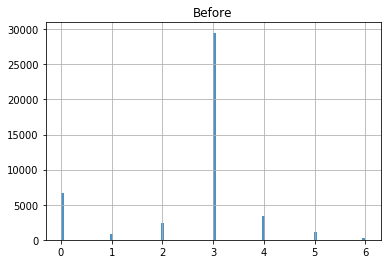

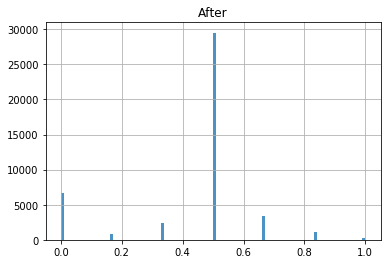

In [11]:
X.Severity.hist(bins=100, alpha=0.8)
plt.title("Before")
plt.show()
plt.close()

X_minmax.Severity.hist(bins=100, alpha=0.8)
plt.title("After")
plt.show()
plt.close()

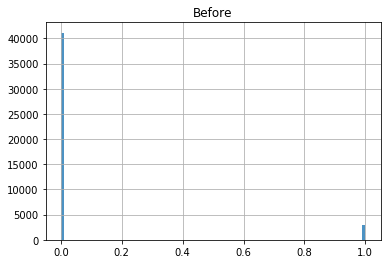

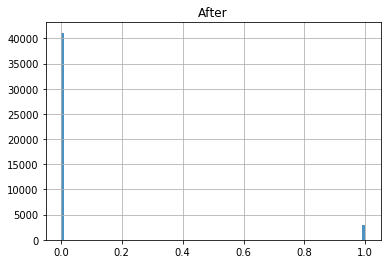

In [12]:
X.Assignee_Eclipse.hist(bins=100, alpha=0.8)
plt.title("Before")
plt.show()
plt.close()

X_minmax.Assignee_Eclipse.hist(bins=100, alpha=0.8)
plt.title("After")
plt.show()
plt.close()

### Standard scaler

This one standardizes features by substracting the mean value and then scaling to unit variance (mean = 0, SD = 1).

In [13]:
# We create a scaler
std_scaler = preprocessing.StandardScaler()

# We need to provide it a sample data (here we will use the whole dataset)
std_scaler.fit(X)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [14]:
# We use it like this
std_scaler.transform(X)

array([[ 3.70461191, -0.78916734, -2.08061271, ..., -0.24632861,
        -0.20303069, -0.15941425],
       [ 3.70461191, -0.78916734,  0.31491381, ..., -0.24632861,
        -0.20303069, -0.15941425],
       [ 3.70461191, -0.78916734,  0.31491381, ..., -0.24632861,
        -0.20303069, -0.15941425],
       ...,
       [-0.26993381,  1.26715837, -2.08061271, ..., -0.24632861,
         4.62844301, -0.15941425],
       [-0.26993381, -0.78916734,  1.11342265, ...,  3.10251155,
        -0.20303069, -0.15941425],
       [-0.26993381,  1.26715837,  0.31491381, ..., -0.24632861,
        -0.20303069, -0.15941425]])

In [15]:
# We can pack it back to a DataFrame
X_std = pd.DataFrame(std_scaler.transform(X), columns=X.columns)
X_std.head(4)

,Assignee_Eclipse,Assignee_Inbox,Severity,Status,Priority,Component_APT,Component_Core,Component_Debug,Component_Doc,Component_Text,...,Summary_npe,Summary_package,Summary_project,Summary_quick,Summary_refactoring,Summary_search,Summary_source,Summary_type,Summary_view,Summary_work
0,3.704612,-0.789167,-2.080613,-1.328284,-4.117538,-0.092438,-0.647638,2.222338,-0.079897,-0.388814,...,-0.200318,-0.187459,-0.181943,-0.170877,-0.210311,-0.15992,-0.188551,-0.246329,-0.203031,-0.159414
1,3.704612,-0.789167,0.314914,0.516320,0.172099,-0.092438,-0.647638,2.222338,-0.079897,-0.388814,...,-0.200318,-0.187459,-0.181943,-0.170877,-0.210311,-0.15992,-0.188551,-0.246329,-0.203031,-0.159414
2,3.704612,-0.789167,0.314914,2.360924,0.172099,-0.092438,-0.647638,2.222338,-0.079897,-0.388814,...,-0.200318,-0.187459,-0.181943,-0.170877,-0.210311,-0.15992,-0.188551,-0.246329,-0.203031,-0.159414
3,3.704612,-0.789167,0.314914,-1.328284,0.172099,-0.092438,-0.647638,2.222338,-0.079897,-0.388814,...,-0.200318,-0.187459,-0.181943,-0.170877,-0.210311,-0.15992,-0.188551,-0.246329,-0.203031,-0.159414


Let's compare distributions of three types of features (scale-wise) before and after the transformation: Days, Severity, and Assignee_Eclipse

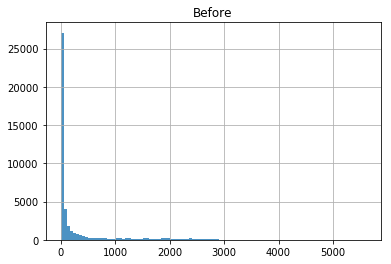

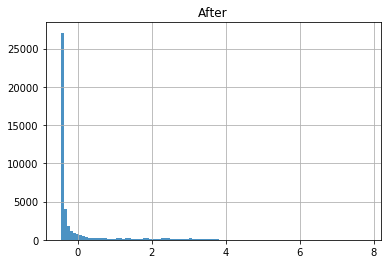

In [16]:
X.Days.hist(bins=100, alpha=0.8)
plt.title("Before")
plt.show()
plt.close()

X_std.Days.hist(bins=100, alpha=0.8)
plt.title("After")
plt.show()
plt.close()

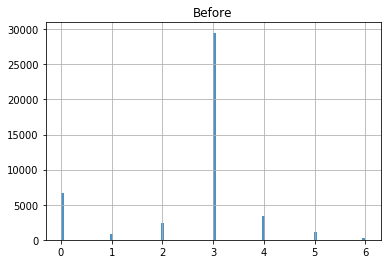

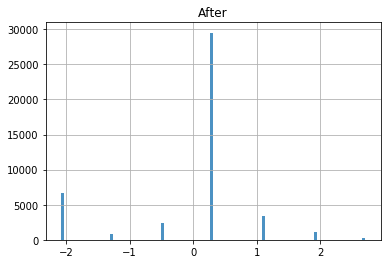

In [17]:
X.Severity.hist(bins=100, alpha=0.8)
plt.title("Before")
plt.show()
plt.close()

X_std.Severity.hist(bins=100, alpha=0.8)
plt.title("After")
plt.show()
plt.close()

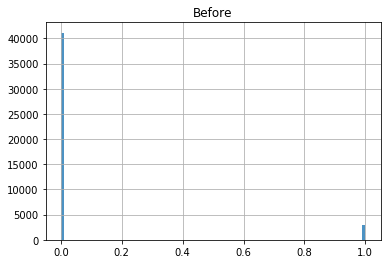

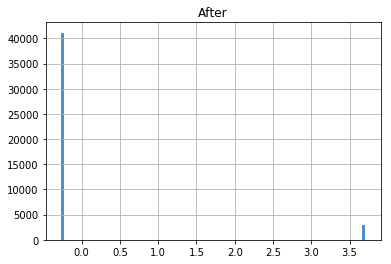

In [18]:
X.Assignee_Eclipse.hist(bins=100, alpha=0.8)
plt.title("Before")
plt.show()
plt.close()

X_std.Assignee_Eclipse.hist(bins=100, alpha=0.8)
plt.title("After")
plt.show()
plt.close()

## Feature selection

There are multiple algorithms for features selection available. The main distinction is between so-called filters, wrappers, and embedded methods. The former tries to evaluate the importance of features by analyzing its relationship between other features or response variable. The second use a given prediction algorithm to construct multiple models using different features and by evaluating their performance they judge which features are potentially the most valuable ones. Finally, the latter are built-in into some of the algorithms (e.g., some ensambles like random forest).

In [19]:
import sklearn.feature_selection as feature_selection

### Low variance

It is a very simple filter which goal is to remove features which variance is smaller than a given threshold. It is the one that it is good to start from.

In [20]:
# We create a filter
var_filter = feature_selection.VarianceThreshold(threshold=0.0) # remove all features with zero variance

# We need to provide it a sample data (here we will use the whole dataset)
var_filter.fit(X)

VarianceThreshold(threshold=0.0)

In [21]:
# We use it like this
var_filter.transform(X)

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 3, ..., 0, 0, 0],
       [1, 0, 3, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 1, 0],
       [0, 0, 4, ..., 1, 0, 0],
       [0, 1, 3, ..., 0, 0, 0]])

In [22]:
# We can pack it back to a DataFrame
X_zero_var = pd.DataFrame(var_filter.transform(X), columns=X.columns)
X_zero_var.head(4)

,Assignee_Eclipse,Assignee_Inbox,Severity,Status,Priority,Component_APT,Component_Core,Component_Debug,Component_Doc,Component_Text,...,Summary_npe,Summary_package,Summary_project,Summary_quick,Summary_refactoring,Summary_search,Summary_source,Summary_type,Summary_view,Summary_work
0,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,3,1,3,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,3,2,3,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,3,0,3,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Filter - Correlation between features

One of the basic filter methos is to remove some of the higly correlated features.

Here a short remark. Always use the appropriate correlation coefficient for the type of data! For simiplicity, we will use Spearman correlation coefficient below, but it is not a good idea to use it for the nominal data...

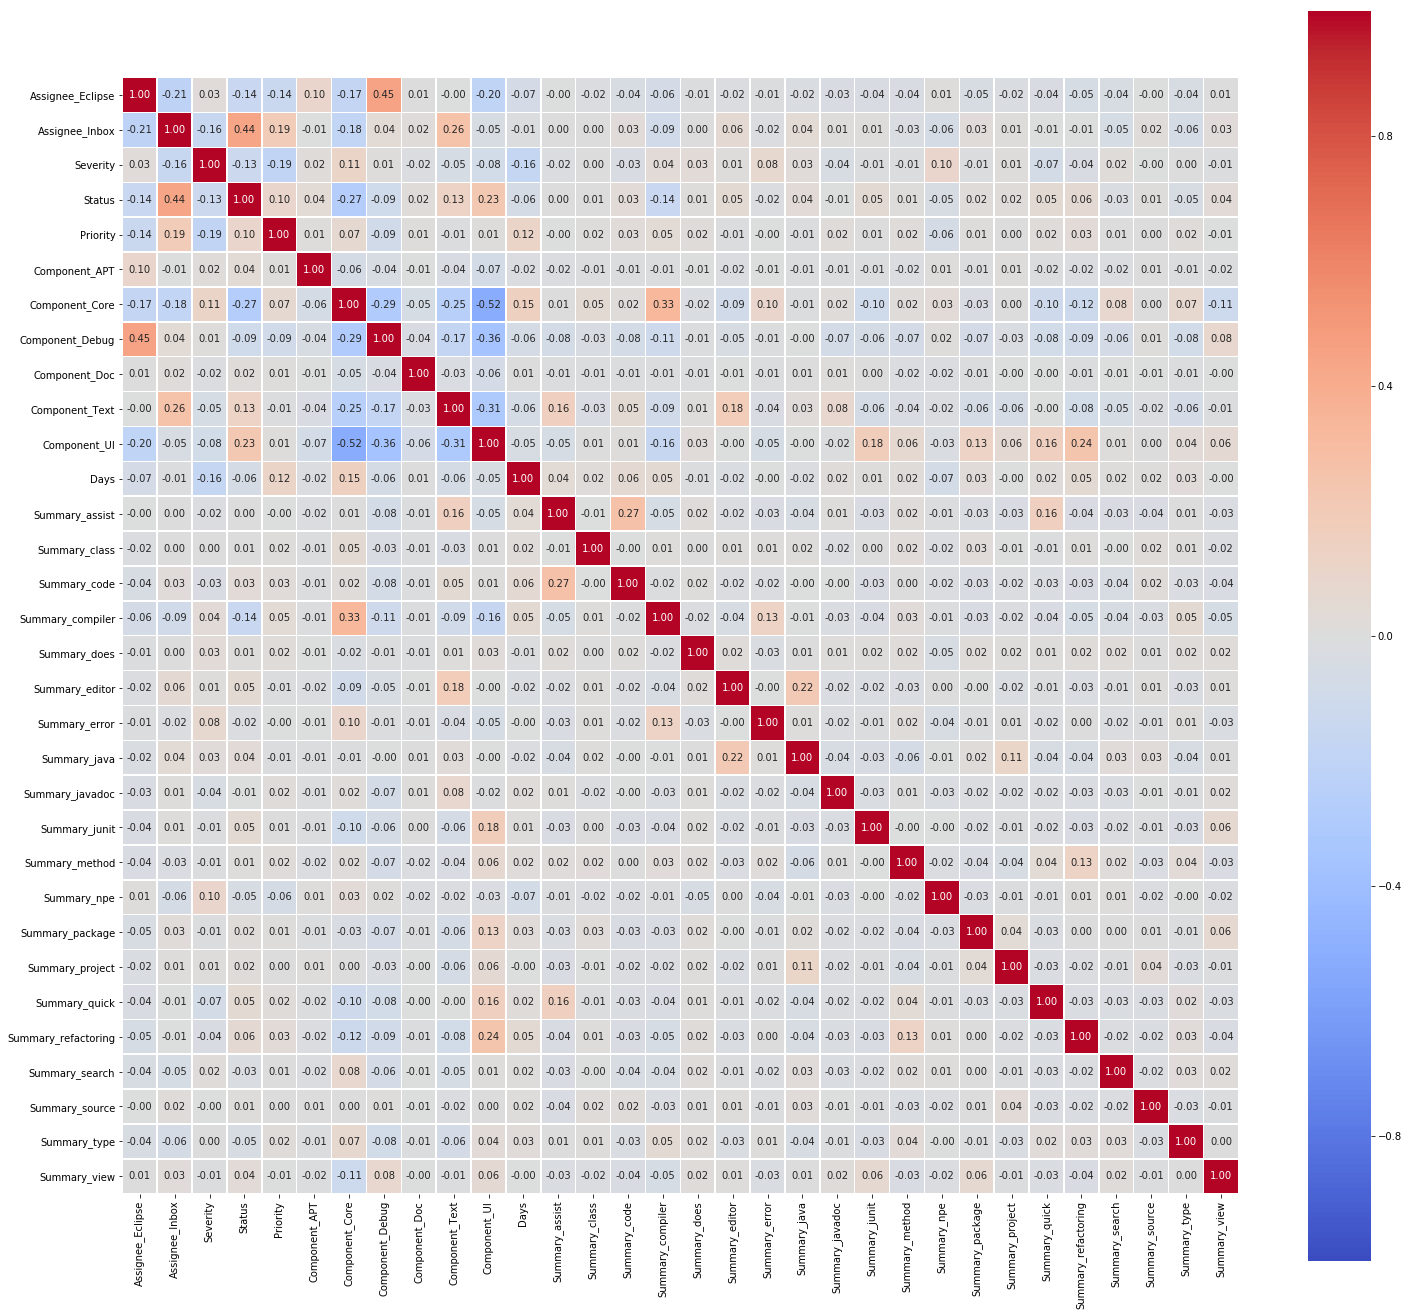

In [44]:
plt.figure(figsize=(25,23))
corrs = X.corr(method="spearman") #pearson, spearman or kendall
#sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
sns.heatmap(corrs, vmin=-1.0, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cmap='coolwarm')

plt.show()

Look at the correlations - what can you learn?

### Filter - Relationship with the output variable

Sklearn offers a few classes for filtering features based on their relationship with the output variables (see https://scikit-learn.org/stable/modules/feature_selection.html). Here, we wil go through a single example.

In [24]:
# We create a filter
kbest_filter = feature_selection.SelectKBest(feature_selection.chi2, k=10) 

# We need to provide it a sample data (here we will use the whole dataset)
kbest_filter.fit(X, y)

SelectKBest(k=10, score_func=<function chi2 at 0x10e70e268>)

In [25]:
# We use it like this
kbest_filter.transform(X)

array([[  1,   0,   0, ...,   7,   0,   0],
       [  1,   0,   3, ...,  48,   0,   0],
       [  1,   0,   3, ..., 258,   0,   0],
       ...,
       [  0,   1,   0, ...,   0,   0,   0],
       [  0,   0,   4, ...,  41,   0,   0],
       [  0,   1,   3, ...,   5,   0,   0]])

In [26]:
# We can pack it back to a DataFrame
cols = kbest_filter.get_support(indices=True)
X_kbest = pd.DataFrame(kbest_filter.transform(X), columns=X.columns[cols])
X_kbest.head(4)

,Assignee_Eclipse,Assignee_Inbox,Severity,Status,Component_APT,Component_Text,Component_UI,Days,Summary_eclipse,Summary_npe
0,1,0,0,0,0,0,0,7,0,0
1,1,0,3,1,0,0,0,48,0,0
2,1,0,3,2,0,0,0,258,0,0
3,1,0,3,0,0,0,0,4800,0,0


### Wrapper - RFE

Feature ranking with recursive feature elimination. You can also look at the RFECV which does a similar thing but uses cross-validation.

In [27]:
# First we need the prediction model for wrapping. Let it be a simple decision tree
from sklearn import tree
predictor = tree.DecisionTreeClassifier()

# We create a filter
rfe_filter = feature_selection.RFE(predictor, n_features_to_select=10, step=5) 

# We need to provide it a sample data (here we will use the whole dataset)
rfe_filter.fit(X, y)

RFE(estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
  n_features_to_select=10, step=5, verbose=0)

In [28]:
# We use it like this
rfe_filter.transform(X)

array([[  0,   0,   0, ...,   7,   0,   0],
       [  0,   3,   1, ...,  48,   0,   0],
       [  0,   3,   2, ..., 258,   0,   0],
       ...,
       [  1,   0,   1, ...,   0,   0,   0],
       [  0,   4,   0, ...,  41,   0,   0],
       [  1,   3,   2, ...,   5,   0,   0]])

In [29]:
# We can pack it back to a DataFrame
cols = rfe_filter.get_support(indices=True)
X_rfe = pd.DataFrame(rfe_filter.transform(X), columns=X.columns[cols])
X_rfe.head(4)

,Assignee_Inbox,Severity,Status,Priority,Component_Core,Component_Text,Component_UI,Days,Summary_code,Summary_java
0,0,0,0,1,0,0,0,7,0,0
1,0,3,1,3,0,0,0,48,0,0
2,0,3,2,3,0,0,0,258,0,0
3,0,3,0,3,0,0,0,4800,0,0


## Pipelines

You can combine multiple scalers, selectors, classifiers, ... into a pipleline. It will have the same API as a prediction model.

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold, SelectKBest

pipeline = Pipeline([
  ('min_max_scaler', preprocessing.MinMaxScaler()),
  ('low_variance_filter', VarianceThreshold(threshold=0.0)),
  ('kbest_chi2_filter', SelectKBest(feature_selection.chi2, k=30)),
  ('classification', RandomForestClassifier())
])

/Users/mochodek/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=2)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [32]:
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(pipeline, X, y, cv=5)

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc = accuracy_score(y, y_pred)
prec = precision_score(y, y_pred, average='macro')
rec = recall_score(y, y_pred, average='macro')
f1 = f1_score(y, y_pred, average='macro')

"Accuracy = {:.3f}, Precision = {:.3f}, Recall = {:.3f}, F1-score = {:.3f}".format(acc, prec, rec, f1)

'Accuracy = 0.571, Precision = 0.347, Recall = 0.330, F1-score = 0.335'

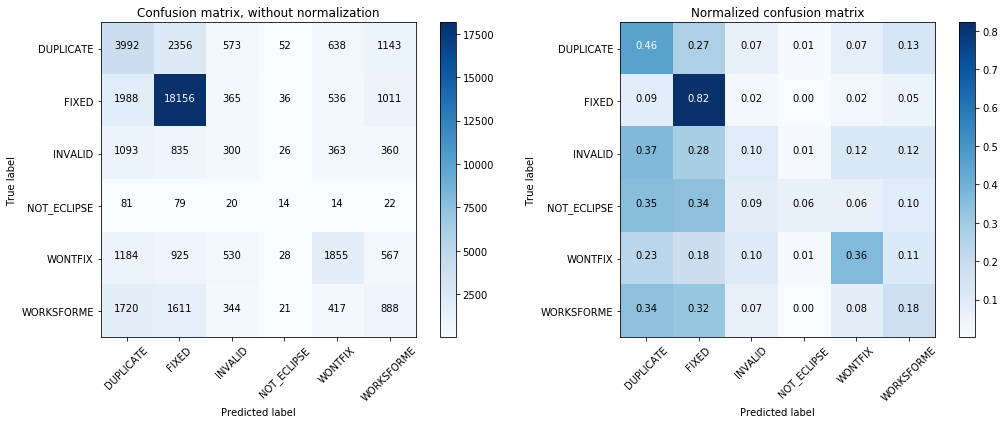

In [34]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y, y_pred)

plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plot_confusion_matrix(cnf_matrix, classes=y_encoder.classes_,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(1, 2, 2)
plot_confusion_matrix(cnf_matrix, classes=y_encoder.classes_, normalize=True,
                      title='Normalized confusion matrix')

## Grid search

Feature engineering is not the only way to improve predictions. Sometimes, it is also about choosing the best values of hyperparameters of the ML algorithm we are using. A brute-force way of doing this is called Grid Search. Yes, it is that simple - just try different combinations of parameters.


In [35]:
from sklearn.model_selection import GridSearchCV

We will try to tune a random forest classifier. Let's try with two hyperparameters:
* n_estimators 
* max_depth

In [36]:
params = {
    "n_estimators" : (10, 30, 50),
    "max_depth" : (2, 3),
}

In [37]:
from sklearn.metrics import make_scorer

search = GridSearchCV(estimator=RandomForestClassifier(), 
                      param_grid=params, 
                      cv=5, 
                      scoring=make_scorer(accuracy_score))
search.fit(X, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': (10, 30, 50), 'max_depth': (2, 3)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(accuracy_score), verbose=0)

In [38]:
search.best_params_

{'max_depth': 3, 'n_estimators': 30}

In [39]:
search.cv_results_

/Users/mochodek/miniconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/mochodek/miniconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/mochodek/miniconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/mochodek/minic

{'mean_fit_time': array([0.18, 0.45, 0.59, 0.17, 0.4 , 0.8 ]),
 'mean_score_time': array([0.02, 0.05, 0.06, 0.02, 0.03, 0.07]),
 'mean_test_score': array([0.53, 0.52, 0.52, 0.57, 0.57, 0.57]),
 'mean_train_score': array([0.54, 0.53, 0.53, 0.59, 0.59, 0.58]),
 'param_max_depth': masked_array(data=[2, 2, 2, 3, 3, 3],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[10, 30, 50, 10, 30, 50],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 2, 'n_estimators': 10},
  {'max_depth': 2, 'n_estimators': 30},
  {'max_depth': 2, 'n_estimators': 50},
  {'max_depth': 3, 'n_estimators': 10},
  {'max_depth': 3, 'n_estimators': 30},
  {'max_depth': 3, 'n_estimators': 50}],
 'rank_test_score': array([4, 6, 5, 3, 1, 2], dtype=int32),
 'split0_test_score': array([0.52, 0.53, 0.52, 0.56, 0.55, 0.54]),
 'split0

We can also tune the parameters of models in the pipeline (we use double underscore to refer to members of the classes).

In [40]:
pipeline = Pipeline([
  ('min_max_scaler', preprocessing.MinMaxScaler()),
  ('low_variance_filter', VarianceThreshold(threshold=0.0)),
  ('kbest_chi2_filter', SelectKBest(feature_selection.chi2, k=30)),
  ('classification', RandomForestClassifier())
])

params = {
    "kbest_chi2_filter__k" : (10, 30),
    "classification__n_estimators" : (10, 30),
}

In [41]:
from sklearn.metrics import make_scorer

search = GridSearchCV(estimator=pipeline, 
                      param_grid=params, 
                      cv=5, 
                      scoring=make_scorer(accuracy_score))
search.fit(X, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('min_max_scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('low_variance_filter', VarianceThreshold(threshold=0.0)), ('kbest_chi2_filter', SelectKBest(k=30, score_func=<function chi2 at 0x10e70e268>)), ('classification', RandomForestClassifier(bootstrap=True, class_weight=None, crite...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kbest_chi2_filter__k': (10, 30), 'classification__n_estimators': (10, 30)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(accuracy_score), verbose=0)

In [42]:
search.best_params_

{'classification__n_estimators': 30, 'kbest_chi2_filter__k': 30}

## Task 1

Use different scalers, feature selectors, and parameters to find the best model to predict bugs resolutions. Let's simplify the problem to binary classification problem -> FIXED / NOT FIXED. The output variable is already available as y_binary.

In [46]:
y_binary

array([1, 0, 0, ..., 0, 0, 0])